
# Titanic - Feature Engineering & Data Preprocessing


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.7f' % x)
pd.set_option('display.width', 500)

In [3]:
def load():
    data = pd.read_csv("datasets/titanic.csv")
    return data

In [4]:
df = load()

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0000000,1,0,A/5 21171,7.2500000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0000000,1,0,PC 17599,71.2833000,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0000000,0,0,STON/O2. 3101282,7.9250000,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0000000,1,0,113803,53.1000000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0000000,0,0,373450,8.0500000,NaN,S


#### Ana hedef insanların hayatta kalıp kalamayacağını bu veri seti üzerinden modellemektir.

In [6]:
# değişken isimlerini tek formata getirelim
df.columns = [col.upper() for col in df.columns]


# 1. Feature Engineering (Değişken Mühendisliği)


In [9]:
# Cabin bool
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int')

In [10]:
# Name count
df["NEW_NAME_COUNT"] = df["NAME"].str.len()

In [11]:
# name word count
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))


In [12]:
# name dr
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

In [13]:
# name title
df['NEW_TITLE'] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)

In [14]:
# family size
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1

In [15]:
# age_pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

In [16]:
# is alone
df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"

In [17]:
# age level
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

In [18]:
# sex x age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [19]:
df.shape   # başlangıçta 12 değişken vardı, şimdi 22

(891, 22)

In [20]:
# Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenleri görelim.
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    # kategorik değişkenleri seç.
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    
    #nümerik görünümlü ama kategorik olanları seç.
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    
    # kategorik görünümlü kardinalleri temizledik
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    # nümerik görününmlü kategorikleri temizledik.
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [21]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [22]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]


# 2. Outliers (Aykırı Değerler)


### eşik değer hesaplama fonksiyonu

In [23]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

### outlier'ları kontrol etmek için 

In [24]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [25]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


### eşik değerler ile aykırı değerleri değiştirelim

In [26]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [27]:
for col in num_cols:
    replace_with_thresholds(df, col)

### tekrar aykırı değerlere bir bakalım

In [28]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False



# 3. Missing Values (Eksik Değerler)


### eksik değer olan kolonları görelim

In [29]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [30]:
missing_values_table(df)

                n_miss      ratio
CABIN              687 77.1000000
AGE                177 19.8700000
NEW_AGE_PCLASS     177 19.8700000
NEW_AGE_CAT        177 19.8700000
EMBARKED             2  0.2200000


In [31]:
# CABIN değişkeni yerine NEW_CABIN_BOOL oluşturmuştuk.CABIN'i silelim.
df.drop("CABIN", inplace=True, axis=1)

In [32]:
remove_cols = ["TICKET", "NAME"]
df.drop(remove_cols, inplace=True, axis=1)

In [33]:
# AGE değişkenindeki eksiklikleri medyanı ile dolduralım.
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

In [34]:
# şimdi AGE değişkeni üzerinden oluşturduklarımızı yeniden oluşturalım.
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

In [35]:
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

In [36]:
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [37]:
# object ve eşsiz değer sayısı 10dan küçük olan kategorikleri modları ile doldurduk.
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)


# 4. Label Encoding


In [38]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

In [39]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [40]:
for col in binary_cols:
    df = label_encoder(df, col)


# 5. Rare Encoding


### Rare kategoriler ile bağımlı değişken arasındaki ilişkinin analiz edileceği fonksiyonumuzu çağıralım

In [41]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


In [42]:
rare_analyser(df, "SURVIVED", cat_cols)

SEX : 2
   COUNT     RATIO  TARGET_MEAN
0    314 0.3524130    0.7420382
1    577 0.6475870    0.1889081


EMBARKED : 3
   COUNT     RATIO  TARGET_MEAN
C    168 0.1885522    0.5535714
Q     77 0.0864198    0.3896104
S    646 0.7250281    0.3390093


NEW_TITLE : 17
          COUNT     RATIO  TARGET_MEAN
Capt          1 0.0011223    0.0000000
Col           2 0.0022447    0.5000000
Countess      1 0.0011223    1.0000000
Don           1 0.0011223    0.0000000
Dr            7 0.0078563    0.4285714
Jonkheer      1 0.0011223    0.0000000
Lady          1 0.0011223    1.0000000
Major         2 0.0022447    0.5000000
Master       40 0.0448934    0.5750000
Miss        182 0.2042649    0.6978022
Mlle          2 0.0022447    1.0000000
Mme           1 0.0011223    1.0000000
Mr          517 0.5802469    0.1566731
Mrs         125 0.1402918    0.7920000
Ms            1 0.0011223    1.0000000
Rev           6 0.0067340    0.0000000
Sir           1 0.0011223    1.0000000


NEW_IS_ALONE : 2
   COUNT     RA

### Rare encoder

In [43]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [44]:
df = rare_encoder(df, 0.01)

In [45]:
df["NEW_TITLE"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: NEW_TITLE, dtype: int64


# 6. One-Hot Encoding


In [46]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [47]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [48]:
df = one_hot_encoder(df, ohe_cols)

In [49]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale
0,1,0,1,22.0000000,7.2500000,0,23.0000000,0,66.0000000,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2,1,0,38.0000000,65.6344000,1,45.0000000,0,38.0000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,0,26.0000000,7.9250000,0,22.0000000,0,78.0000000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,35.0000000,53.1000000,1,44.0000000,0,35.0000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,1,35.0000000,8.0500000,0,24.0000000,0,105.0000000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [50]:
df.shape

(891, 50)

In [51]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 50
cat_cols: 45
num_cols: 5
cat_but_car: 0
num_but_cat: 45


In [52]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

In [53]:
# OHE'dan geçirdiğimiz yeni değişkenlerin hepsinin gerekli olup olmadığını bilmiyoruz
# bunu sorgulamak için RARE ANALYSER i tekrar inceleyelim

In [54]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
   COUNT     RATIO  TARGET_MEAN
0    549 0.6161616            0
1    342 0.3838384            1


SEX : 2
   COUNT     RATIO  TARGET_MEAN
0    314 0.3524130    0.7420382
1    577 0.6475870    0.1889081


NEW_CABIN_BOOL : 2
   COUNT     RATIO  TARGET_MEAN
0    687 0.7710438    0.2998544
1    204 0.2289562    0.6666667


NEW_NAME_DR : 2
   COUNT     RATIO  TARGET_MEAN
0    881 0.9887767    0.3825199
1     10 0.0112233    0.5000000


NEW_IS_ALONE : 2
   COUNT     RATIO  TARGET_MEAN
0    354 0.3973064    0.5056497
1    537 0.6026936    0.3035382


PCLASS_2 : 2
   COUNT     RATIO  TARGET_MEAN
0    707 0.7934905    0.3606789
1    184 0.2065095    0.4728261


PCLASS_3 : 2
   COUNT     RATIO  TARGET_MEAN
0    400 0.4489338    0.5575000
1    491 0.5510662    0.2423625


SIBSP_1 : 2
   COUNT     RATIO  TARGET_MEAN
0    682 0.7654321    0.3372434
1    209 0.2345679    0.5358852


SIBSP_2 : 2
   COUNT     RATIO  TARGET_MEAN
0    863 0.9685746    0.3812283
1     28 0.0314254    0.46428

In [55]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

In [56]:
useless_cols #bunları siledebiliriz.

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

In [57]:
# df.drop(useless_cols, axis=1, inplace=True)


# 7. Standart Scaler


In [58]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df[num_cols].head()

,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-0.5606383,-0.8205524,-0.4366754,0.0664885
1,0.6633017,2.0316232,2.2483028,-0.7904288
2,-0.2546533,-0.7875776,-0.5587198,0.4337387
3,0.4338129,1.4192968,2.1262584,-0.8822414
4,0.4338129,-0.7814711,-0.3146309,1.2600518



# 8. Model


In [59]:
# bağımlı değişken Survived
y = df["SURVIVED"]

In [60]:
# bağımsız değişkenler PASSENGERID VE SURVIVED dışındaki değişkenler
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)

In [64]:
y_pred = rf_model.predict(X_test)

In [65]:
accuracy_score(y_pred, y_test)

0.8059701492537313

In [69]:
# Yeni ürettiğimiz anlamlı mı anlamsız mı?
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

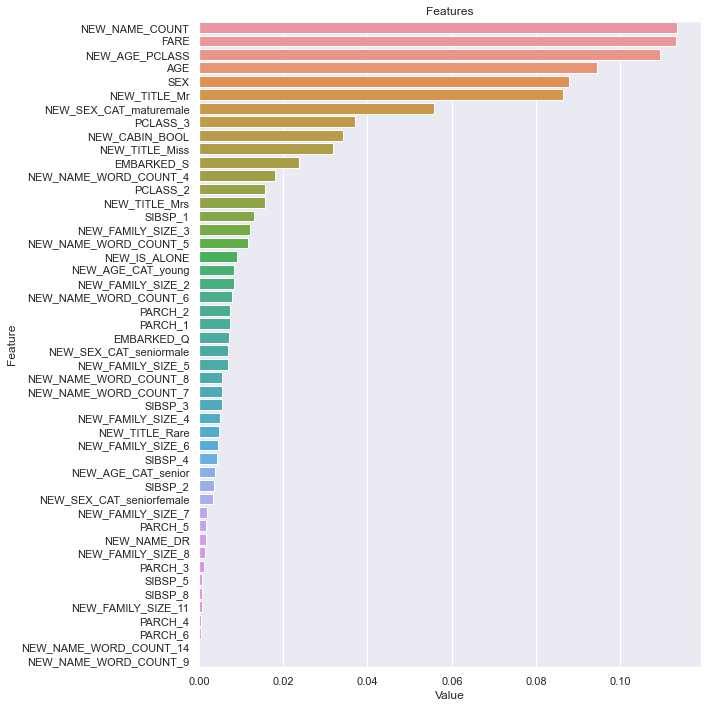

In [70]:
plot_importance(rf_model, X_train)

In [71]:
###################################################
# Yukarıdaki işlemleri yapmasaydık sonuç ne olurdu?
###################################################

sadece en gerekli işlemleri yapalım.

In [73]:
dff = load()

In [74]:
# eksik verileri sildik.
dff.dropna(inplace=True)

In [75]:
# matematiksel forma çevirelim
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)

In [76]:
# bağımlı ve bağımsız dğeişkenleri seçtik
y = dff["Survived"]
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

In [77]:
# modeli tekrar kuralım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [78]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [79]:
accuracy_score(y_pred, y_test)

0.7090909090909091

Feature Engineering & Data Preprocessing işlemlerini yaparak 0.70 accuracy yerine 0.80 sonucuna ulaştık.